In [1]:
# -*- coding: utf8

from scipy import stats as ss

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [2]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [3]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

# Aula 19 - Regressão Múltipla

Continuando da aula passada, vamos agora focar em casos mais específicos de regressão. Nesta aula, vamos estender a ideia de mínimos quadrados e de regressão linear para modelos mais complexos. Para tal, vamos continuar nosso foco nos dados de preços de apartamentos em BH.

## Dados

Observe como temos 4 possíveis preditores de preço:
1. Area
1. Quartos
1. Suites
1. Vagas

In [4]:
df = pd.read_csv('https://media.githubusercontent.com/media/icd-ufmg/material/master/aulas/19-Multipla/aptosBH.txt', encoding='iso-8859-1', na_values='unknown', index_col=0)
df.head()

,area,quartos,suites,vagas,preco
ID,,,,,
353534.0,110.00,3.0,1.0,2.0,880000.0
366113.0,101.89,3.0,1.0,4.0,900000.0
186728.0,191.00,3.0,1.0,3.0,920000.0
366115.0,101.89,3.0,1.0,4.0,950000.0
353022.0,280.61,3.0,1.0,4.0,1000000.0


Cada preditor é de uma forma correlacionado com o preço. No pairplot abaixo, preste atenção na última coluna.

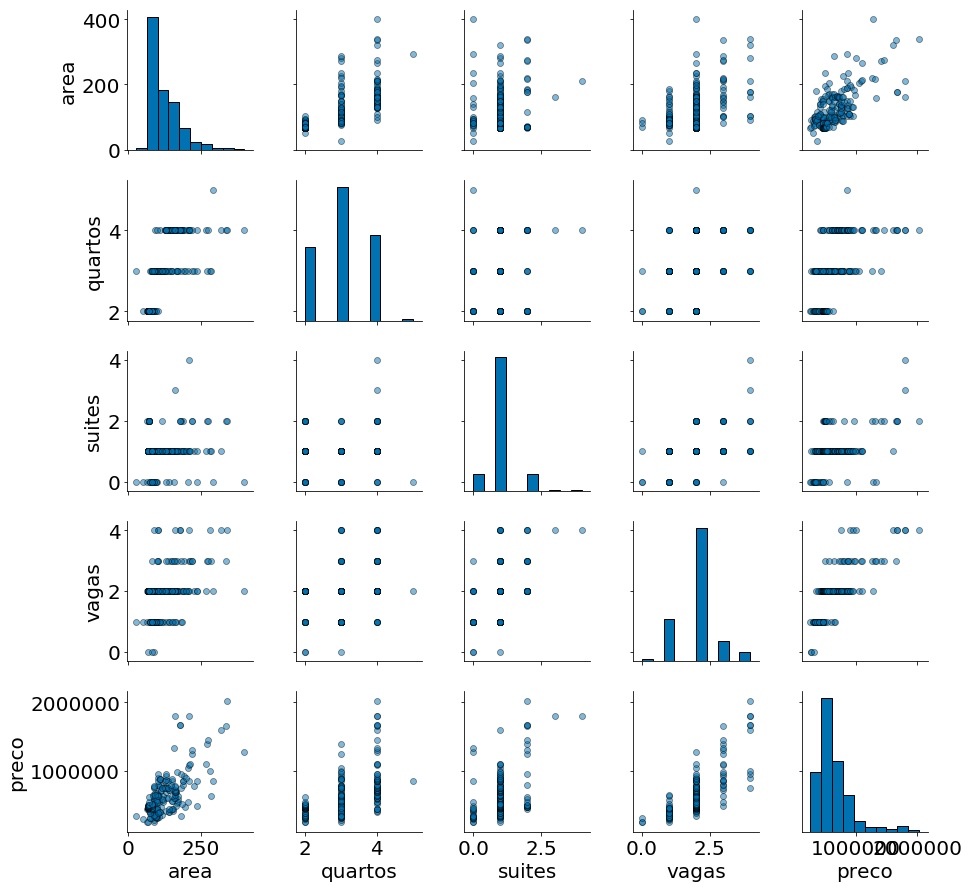

In [5]:
sns.pairplot(df, diag_kws={'edgecolor':'k'}, plot_kws={'alpha':0.5, 'edgecolor':'k'})

## Regressão Múltipla

Para realizar uma regressão múltipla, vamos representar nossos dados na forma matricial. Sendo `n` o número de linhas nos nossos dados (observações) e `f` o número de colunas (features/atríbutos). Os dados podem ser vistos como a matriz abaixo:

$$
\mathbf{X} = \begin{pmatrix}\mathbf {x} _{1}^{\mathsf {T}}\\\mathbf {x} _{2}^{\mathsf {T}}\\\vdots \\\mathbf {x} _{n}^{\mathsf {T}}\end{pmatrix} =\begin{pmatrix}1&x_{11}&\cdots &x_{1f}\\1&x_{21}&\cdots &x_{2f}\\\vdots &\vdots &\ddots &\vdots \\1&x_{n1}&\cdots &x_{nf}\end{pmatrix}
$$

Observe como a primeira coluna é toda `1`. A mesma vai capturar o fator constante, intercepto, da regressão linear. O nosso modelo é capturado pela equação abaixo:

$$y_i = \theta_0 x_{i0} + \theta_1 x_{i1}^{1} + \theta_2 x_{i2}^{2} + \cdots + \theta_f x_{if}^{f} + \epsilon_i$$.

Aqui, $x_{i0} = 1$ sempre! Por isso usamos uma coluna de 1s.

$$y_i = \theta_0 + \theta_1 x_{i1}^{1} + \theta_2 x_{i2}^{2} + \cdots + \theta_f x_{if}^{f} + \epsilon_i$$.

Vamos organizar uma matrix de fatores explanatórios X usando pandas.

In [6]:
y = df['preco']
X = df[['area', 'quartos', 'suites', 'vagas']]
X['intercepto'] = 1
X = X[['intercepto', 'area', 'quartos', 'suites', 'vagas']]
X.head()

,intercepto,area,quartos,suites,vagas
ID,,,,,
353534.0,1,110.00,3.0,1.0,2.0
366113.0,1,101.89,3.0,1.0,4.0
186728.0,1,191.00,3.0,1.0,3.0
366115.0,1,101.89,3.0,1.0,4.0
353022.0,1,280.61,3.0,1.0,4.0


Temos 216 observações.

In [7]:
y.shape

(216,)

5 atributos, onde um deles é o intercepto.

In [8]:
X.shape

(216, 5)

```python
X.values
```

retorna a matriz.

In [9]:
X = X.values
y = y.values # pegar a matrix
X

array([[   1.  ,  110.  ,    3.  ,    1.  ,    2.  ],
       [   1.  ,  101.89,    3.  ,    1.  ,    4.  ],
       [   1.  ,  191.  ,    3.  ,    1.  ,    3.  ],
       ..., 
       [   1.  ,   70.  ,    2.  ,    2.  ,    2.  ],
       [   1.  ,   70.  ,    2.  ,    2.  ,    2.  ],
       [   1.  ,  115.  ,    3.  ,    1.  ,    2.  ]])

Sendo $\mathbf{y}$ a nossa resposta. Na forma matricial o nosso modelo tem a seguinte forma:


$$\mathbf {y} =\mathbf{X}{\boldsymbol {\theta }}+{\boldsymbol {\varepsilon }} $$

Observa na figura abaixo como cada observação $y_i$ vai ser capturada pelo modelo linear $y_i = \theta_0 + \theta_1 x_{i1}^{1} + \theta_2 x_{i2}^{2} + \cdots + \theta_f x_{if}^{f} + \epsilon_i$. Basta pensar em operações de matrizes e vetores como somatórios! Cada linha de $\mathbf{X}$ multiplica um vetor de parâmetros $\theta$.

![](./f.png)

Nossa função de perda na forma matricial é:

$$L({\boldsymbol {\theta }}) = n^{-1} ||\mathbf{y} - \mathbf{X} {\boldsymbol {\theta }}||^2_2$$

A bela arte abaixo demonstra a ideia. Enquanto multplicação de matrizes capturam somatórios, a norma L2 (acima) capturam uma soma ao quadrado. 

![](./f2.png)

Um fator bastante interessante deste modelo é que todas as derivadas (para cada $\theta_i$) têm a mesma forma. Para chegar neste resultado, basta observar que na regressão simples a derivada da inclinação da curva é $L'(\beta) = 2 n^{-1} \sum e_i x_i$. Como temos uma soma de fatores lineares, cada $\theta_i$ vai ter o mesmo formato. Assim:

$$\frac{dL}{d\theta_j} = -2n^{-1} \sum_{i=1}^{n} (y_i - \sum_{j=0} \theta_j x_{ij}) x_{ij}$$

$$\frac{dL}{d\theta_j} = -2n^{-1} \sum_{i=1}^{n} \epsilon_i x_{ij}$$

A função abaixo computa tal derivada explorando broadcasting em numpy. Ver nos slides a discussão de como a mesma funciona.

In [10]:
def derivadas_regressao(theta, X, y):
    return -2 * ((y - X @ theta) * X.T).mean(axis=1)

Agora podemos realizar gradiente descendente!

In [11]:
def gd(theta, d_fun, X, y, lambda_=0.01, tol=0.00001, max_iter=10000):
    theta = theta.copy()
    print('Iter {}; theta = '.format(0), theta)
    old_err_sq = np.inf
    i = 0
    while True:
        # Computar as derivadas
        grad = d_fun(theta, X, y)
        # Atualizar
        theta_novo = theta - lambda_ * grad
        
        # Parar quando o erro convergir
        err_sq = ((X.dot(theta) - y) ** 2).mean()
        if np.abs(old_err_sq - err_sq) <= tol:
            break
        theta = theta_novo
        old_err_sq = err_sq
        print('Iter {}; theta = '.format(i+1), theta)
        i += 1
        if i == max_iter:
            break
    return theta

Caso queira, normalize os dados para nos ajudar no gradiente. O algoritmo funciona sem tal passo, porém demora mais tempo para finalizar.

In [12]:
df = pd.read_csv('https://media.githubusercontent.com/media/icd-ufmg/material/master/aulas/19-Multipla/aptosBH.txt', encoding='iso-8859-1', na_values='unknown', index_col=0)
df = df - df.mean()
df = df / df.std(ddof=1)

y = df['preco']
X = df[['area', 'quartos', 'suites', 'vagas']]
X['intercepto'] = 1

X = X.values
y = y.values

theta = np.ones(5)
theta = gd(theta, derivadas_regressao, X, y)
theta

Iter 0; theta =  [ 1.  1.  1.  1.  1.]
Iter 1; theta =  [ 0.96965016  0.96989804  0.97556218  0.97103314  0.98      ]
Iter 2; theta =  [ 0.9406106   0.94101718  0.95201827  0.94331228  0.9604    ]
Iter 3; theta =  [ 0.91282625  0.91330653  0.92933306  0.91678573  0.941192  ]
Iter 4; theta =  [ 0.88624437  0.88671737  0.90747276  0.89140395  0.92236816]
Iter 5; theta =  [ 0.86081439  0.86120297  0.88640494  0.86711945  0.9039208 ]
Iter 6; theta =  [ 0.83648787  0.83671857  0.8660985   0.84388667  0.88584238]
Iter 7; theta =  [ 0.81321837  0.81322127  0.84652359  0.82166198  0.86812553]
Iter 8; theta =  [ 0.79096142  0.79066997  0.82765156  0.80040349  0.85076302]
Iter 9; theta =  [ 0.76967436  0.76902526  0.80945492  0.78007109  0.83374776]
Iter 10; theta =  [ 0.74931635  0.7482494   0.7919073   0.7606263   0.81707281]
Iter 11; theta =  [ 0.72984823  0.72830622  0.77498338  0.74203222  0.80073135]
Iter 12; theta =  [ 0.71123249  0.70916103  0.75865886  0.72425351  0.78471672]
Iter 13; t

Iter 247; theta =  [ 0.37086032  0.15987097  0.2072534   0.43574842  0.0068052 ]
Iter 248; theta =  [ 0.37101888  0.15962666  0.20704621  0.43595526  0.00666909]
Iter 249; theta =  [ 0.37117639  0.15938418  0.20684113  0.43616016  0.00653571]
Iter 250; theta =  [ 0.37133286  0.1591435   0.20663814  0.43636313  0.006405  ]
Iter 251; theta =  [ 0.37148828  0.15890461  0.20643722  0.43656418  0.0062769 ]
Iter 252; theta =  [ 0.37164267  0.15866749  0.20623835  0.43676334  0.00615136]
Iter 253; theta =  [ 0.37179603  0.15843215  0.2060415   0.43696061  0.00602833]
Iter 254; theta =  [ 0.37194837  0.15819855  0.20584665  0.43715601  0.00590777]
Iter 255; theta =  [ 0.37209971  0.15796669  0.20565378  0.43734957  0.00578961]
Iter 256; theta =  [ 0.37225003  0.15773655  0.20546287  0.43754129  0.00567382]
Iter 257; theta =  [ 0.37239936  0.15750813  0.20527389  0.43773119  0.00556034]
Iter 258; theta =  [ 0.3725477   0.15728141  0.20508683  0.43791928  0.00544913]
Iter 259; theta =  [ 0.37269

array([ 0.37582774,  0.1523183 ,  0.20112098,  0.44193077,  0.00335547])

In [13]:
theta

array([ 0.37582774,  0.1523183 ,  0.20112098,  0.44193077,  0.00335547])

Observe como os resultados batem com o scikit learn.

In [14]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
model.coef_

array([ 0.39547414,  0.12651004,  0.18641188,  0.45621635,  0.        ])

In [16]:
model.intercept_

3.9300690053159642e-16

Com SGD também funciona! Temos que acetar a taxa de aprendizado.

In [17]:
def sgd(theta, d_fun, X, y, lambda_=0.001, tol=0.00001, max_iter=10000):
    theta = theta.copy()
    print('Iter {}; alpha, beta = '.format(0), theta)
    old_err_sq = np.inf
    for i in range(1000):
        # Escolhe ponto aleatório
        r = np.random.randint(len(y))
        X_r, y_r = X[r], y[r]
        X_r = X_r[None] # np.array([1, 2])[None] -> [[1, 2]]. Vira matriz
        
        # Deriva e atualiza
        grad = d_fun(theta, X_r, y_r)
        theta_novo = theta - lambda_ * grad
        err_sq = ((X.dot(theta) - y) ** 2).mean()
        
        theta = theta_novo
        old_err_sq = err_sq
        
        print('Iter {}; alpha, beta = '.format(i+1), theta)
        if i == max_iter:
            break
    return theta

In [18]:
df = pd.read_csv('https://media.githubusercontent.com/media/icd-ufmg/material/master/aulas/19-Multipla/aptosBH.txt', encoding='iso-8859-1', na_values='unknown', index_col=0)
df = df - df.mean()
df = df / df.std(ddof=1)

y = df['preco']
X = df[['area', 'quartos', 'suites', 'vagas']]

X = X.values
y = y.values

theta = np.ones(4)
theta = sgd(theta, derivadas_regressao, X, y, lambda_=0.002)
theta

Iter 0; alpha, beta =  [ 1.  1.  1.  1.]
Iter 1; alpha, beta =  [ 1.00001877  1.0000196   1.00001296  0.9999837 ]
Iter 2; alpha, beta =  [ 0.99729811  1.00026844  1.00017755  0.99481128]
Iter 3; alpha, beta =  [ 0.98975804  0.99169158  1.00048194  0.99442862]
Iter 4; alpha, beta =  [ 0.99056821  0.99294449  0.99878735  0.99437814]
Iter 5; alpha, beta =  [ 0.98209465  0.96959116  0.9657044   0.97273688]
Iter 6; alpha, beta =  [ 0.97915434  0.96112748  0.96600477  0.97235928]
Iter 7; alpha, beta =  [ 0.97623528  0.952725    0.96630298  0.9719844 ]
Iter 8; alpha, beta =  [ 0.97496257  0.95258514  0.96621048  0.97210068]
Iter 9; alpha, beta =  [ 0.97206589  0.94424709  0.96650639  0.97172868]
Iter 10; alpha, beta =  [ 0.96757623  0.93531588  0.96622015  0.97208853]
Iter 11; alpha, beta =  [ 0.96594922  0.93063257  0.96638636  0.97187958]
Iter 12; alpha, beta =  [ 0.96653162  0.93057541  0.96634856  0.97078664]
Iter 13; alpha, beta =  [ 0.96184527  0.91887638  0.96676375  0.97026469]
Iter 1

Iter 399; alpha, beta =  [ 0.30735525  0.27828657  0.41461579  0.38150927]
Iter 400; alpha, beta =  [ 0.30685171  0.27824024  0.41458514  0.38062313]
Iter 401; alpha, beta =  [ 0.30659396  0.27812288  0.41450752  0.38072071]
Iter 402; alpha, beta =  [ 0.30598139  0.27723798  0.41447916  0.38075637]
Iter 403; alpha, beta =  [ 0.30526087  0.27571219  0.41453331  0.38068829]
Iter 404; alpha, beta =  [ 0.30507716  0.275692    0.41451995  0.38070508]
Iter 405; alpha, beta =  [ 0.30465397  0.27554803  0.41442473  0.38082478]
Iter 406; alpha, beta =  [ 0.30435895  0.27512185  0.41441107  0.38084195]
Iter 407; alpha, beta =  [ 0.30138632  0.27005434  0.40723231  0.37614595]
Iter 408; alpha, beta =  [ 0.30083775  0.26926189  0.40720691  0.37617788]
Iter 409; alpha, beta =  [ 0.30059171  0.26890647  0.40719552  0.3761922 ]
Iter 410; alpha, beta =  [ 0.29668078  0.26147948  0.39667424  0.36212794]
Iter 411; alpha, beta =  [ 0.29879378  0.26488898  0.39206279  0.36199057]
Iter 412; alpha, beta =  

Iter 776; alpha, beta =  [ 0.39834196  0.22100668  0.33093     0.47030691]
Iter 777; alpha, beta =  [ 0.39827077  0.22089658  0.33092647  0.47031134]
Iter 778; alpha, beta =  [ 0.39798439  0.22084814  0.33089443  0.46938502]
Iter 779; alpha, beta =  [ 0.39820015  0.22086999  0.33090888  0.4698028 ]
Iter 780; alpha, beta =  [ 0.3999097   0.21548112  0.33110013  0.46379224]
Iter 781; alpha, beta =  [ 0.39998399  0.21538546  0.33103686  0.46387178]
Iter 782; alpha, beta =  [ 0.39632813  0.20844286  0.32120178  0.45743815]
Iter 783; alpha, beta =  [ 0.39669175  0.20880694  0.32118886  0.45745439]
Iter 784; alpha, beta =  [ 0.39644314  0.20876312  0.32115988  0.45749082]
Iter 785; alpha, beta =  [ 0.39377942  0.20629331  0.32503416  0.45738063]
Iter 786; alpha, beta =  [ 0.39257529  0.20335269  0.32513852  0.46039811]
Iter 787; alpha, beta =  [ 0.39181691  0.20346983  0.325216    0.46030072]
Iter 788; alpha, beta =  [ 0.39127753  0.2034015   0.32517081  0.46035753]
Iter 789; alpha, beta =  

array([ 0.38304675,  0.15422148,  0.27773105,  0.43954316])

Um dos problemas do nosso uso recorrente de SGD é que não dizemos ainda como acetar nossa taxa. Para tal, geralmente fazemos uso de treino/validação/teste (assunto da próxima aula).

## Bootstrap para entender a importância de fatores

De forma similar como fizemos na regressão simples, podemos aplicar um bootstrap aqui para entender a importância dos fatores. Nós repetidamente tomamos um `bootstrap_regression` dos nossos dados e estimamos o vetor `\Theta` com base nessa amostra. Se o coeficiente correspondente a uma das variáveis independentes não variar muito entre as amostras, podemos ter certeza de que nossa estimativa é relativamente segura. Se o coeficiente variar muito entre as amostras, não podemos ficar confiantes em nossa estimativa. Caso o intervalo capture o zero, o fator não importa do ponto de vista estatístico. Abaixo, assim como nas próxima aulas, já vamos fazer uso de scikit learn direto.

Vamos ver exemplos em duas bases.

(1) Exemplo nos dados dos apartamentos.

In [19]:
def bootstrap_regression(X, y, n=10000, size=None):
    if size is None:
        size = len(df)
        
    T = np.zeros(shape=(n, X.shape[1]))
    for i in range(n):
        # Gera amostras com reposição
        idx = np.random.choice(len(y), len(y))
        Xb = X[idx]
        yb = y[idx]
        
        # Fit usando sklearn
        model = LinearRegression(fit_intercept=True)
        model.fit(Xb, yb)
        
        T[i] = model.coef_
    return T

In [20]:
y = df['preco'].values
names = ['area', 'quartos', 'suites', 'vagas']
X = df[names].values
T = bootstrap_regression(X, y)

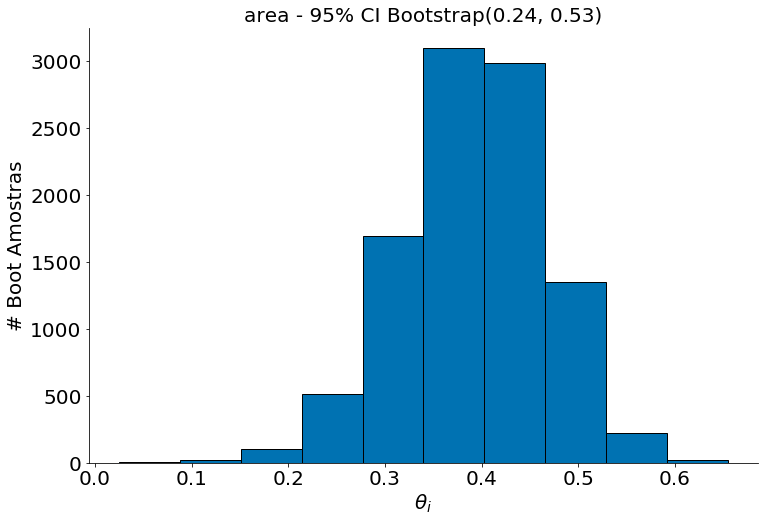

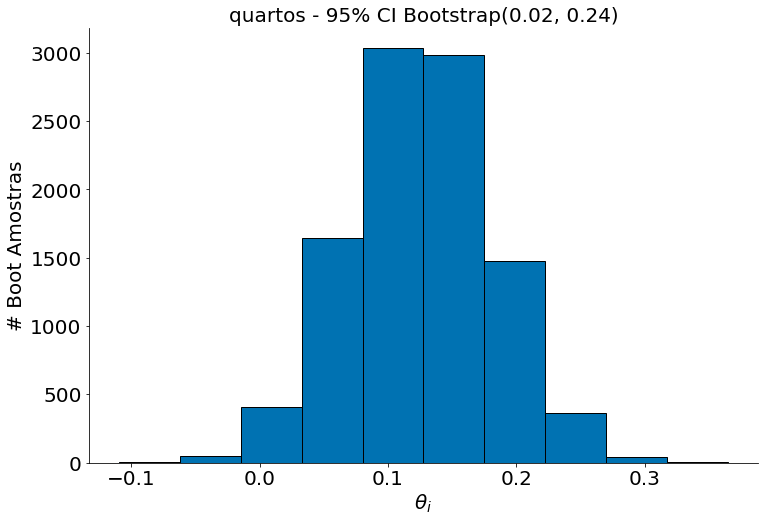

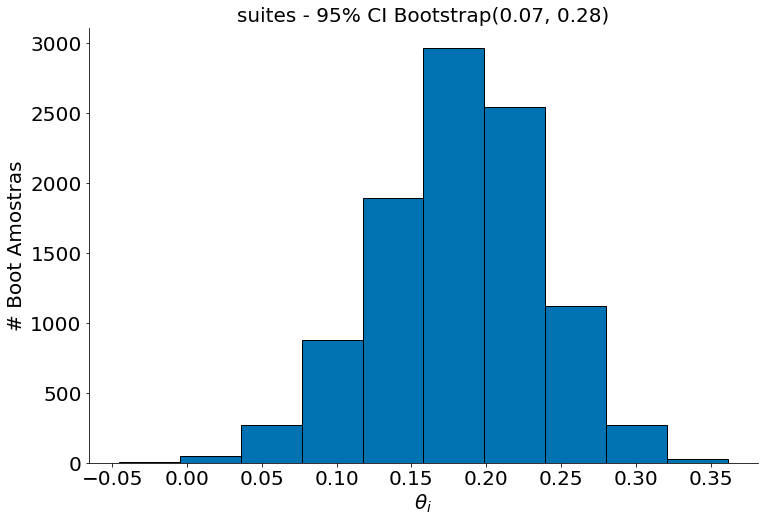

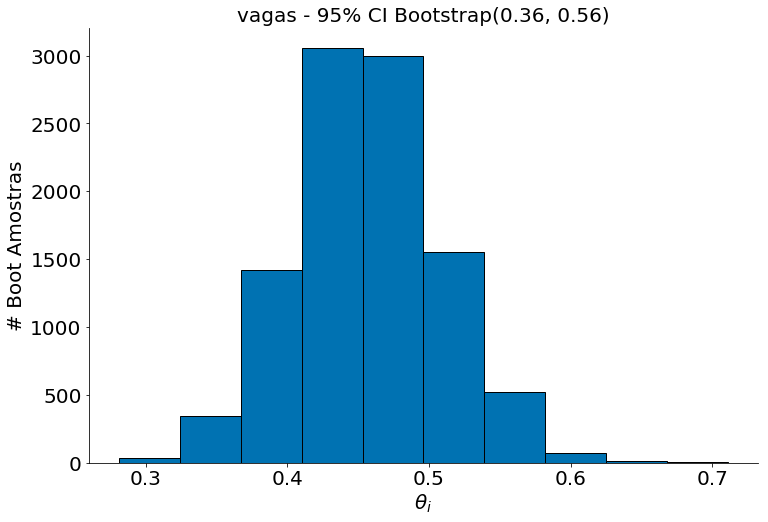

In [21]:
for col in range(T.shape[1]):
    plt.hist(T[:, col], edgecolor='k')
    plt.title('{} - 95% CI Bootstrap({:.2f}, {:.2f})'.format(names[col],
                                                             np.percentile(T[:, col], 2.5),
                                                             np.percentile(T[:, col], 97.5)))
    plt.xlabel(r'$\theta_i$')
    plt.ylabel('# Boot Amostras')
    despine()
    plt.show()

(2) Exemplo com a base dos carros. Aqui teremos fatores não relevantes. Procure o gráfico onde o CI do boostract contém o zero.

In [22]:
df = pd.read_csv('https://media.githubusercontent.com/media/icd-ufmg/material/master/aulas/19-Multipla/hybrid.csv', encoding='iso-8859-1', na_values='unknown')
df.head()

,vehicle,year,msrp,acceleration,mpg,class
0,Prius (1st Gen),1997,24509.74,7.46,41.26,Compact
1,Tino,2000,35354.97,8.20,54.10,Compact
2,Prius (2nd Gen),2000,26832.25,7.97,45.23,Compact
3,Insight,2000,18936.41,9.52,53.00,Two Seater
4,Civic (1st Gen),2001,25833.38,7.04,47.04,Compact


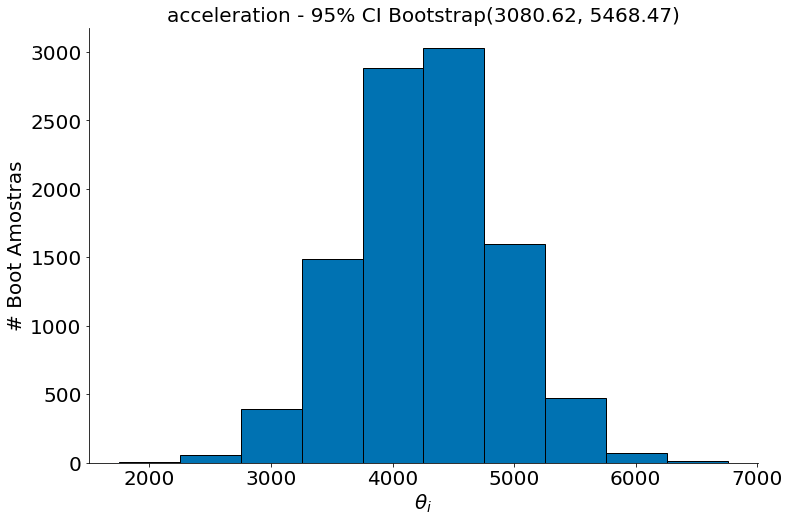

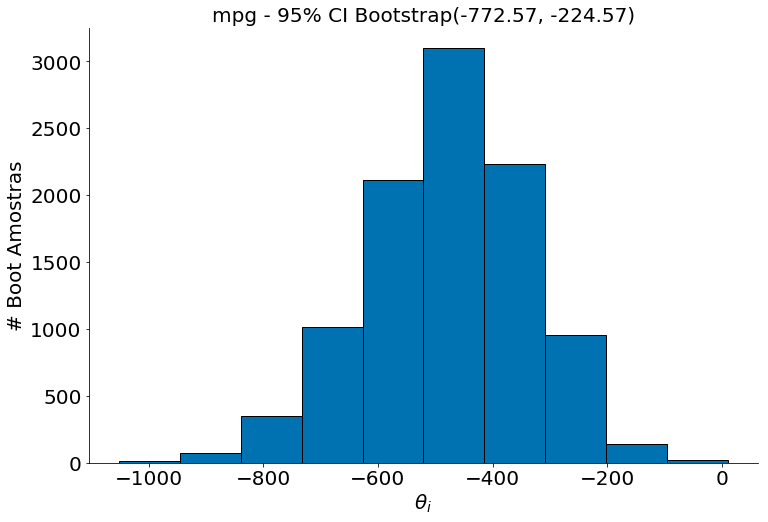

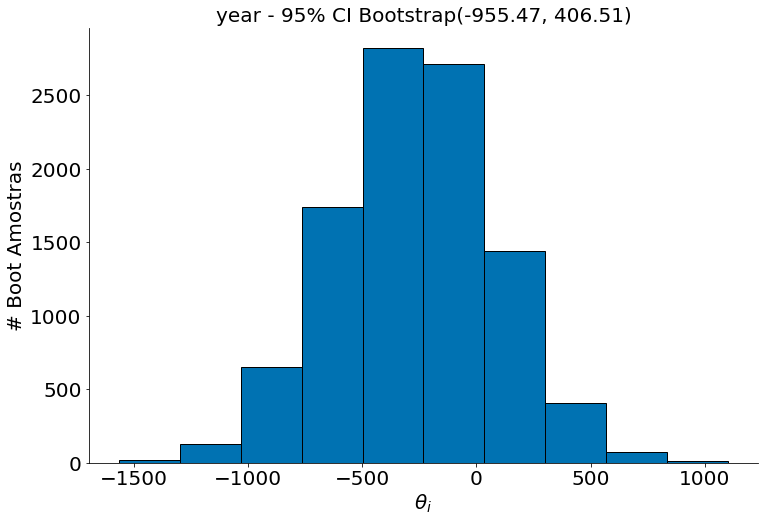

In [23]:
y = df['msrp'].values
names = ['acceleration', 'mpg', 'year']
X = df[names].values
T = bootstrap_regression(X, y)
for col in range(T.shape[1]):
    plt.hist(T[:, col], edgecolor='k')
    plt.title('{} - 95% CI Bootstrap({:.2f}, {:.2f})'.format(names[col],
                                                             np.percentile(T[:, col], 2.5),
                                                             np.percentile(T[:, col], 97.5)))
    plt.xlabel(r'$\theta_i$')
    plt.ylabel('# Boot Amostras')
    despine()
    plt.show()

## Regressão Polinomial

WIP

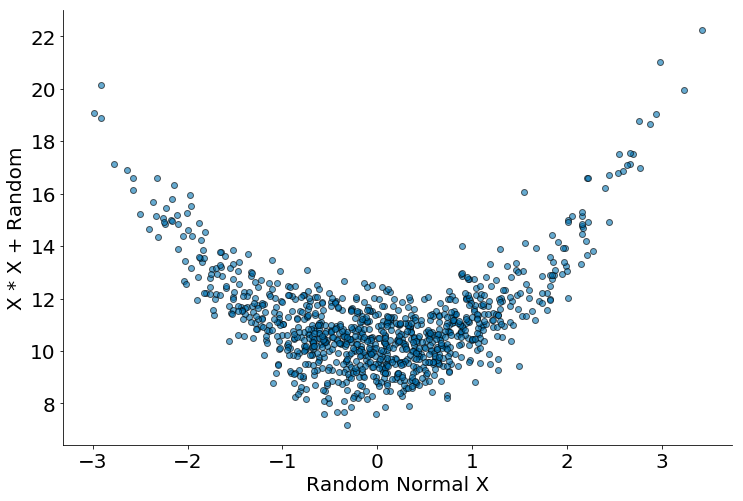

In [24]:
x = np.random.randn(1000)
y = x * x + np.random.randn(1000) + 10
plt.scatter(x, y, edgecolor='k', alpha=0.6)
plt.xlabel('Random Normal X')
plt.ylabel('X * X + Random')
despine()

In [25]:
X = np.zeros(shape=(len(x), 2))
X[:, 0] = 1
X[:, 1] = x * x
X

array([[ 1.        ,  0.17996087],
       [ 1.        ,  0.61811761],
       [ 1.        ,  0.1118815 ],
       ..., 
       [ 1.        ,  2.16106978],
       [ 1.        ,  0.04784179],
       [ 1.        ,  0.08978165]])

In [26]:
theta = np.ones(2)
theta = gd(theta, derivadas_regressao, X, y, lambda_=0.01)

Iter 0; theta =  [ 1.  1.]
Iter 1; theta =  [ 1.18039484  1.19252872]
Iter 2; theta =  [ 1.35306598  1.36721152]
Iter 3; theta =  [ 1.51854939  1.52551022]
Iter 4; theta =  [ 1.67733909  1.66876899]
Iter 5; theta =  [ 1.82989047  1.79822375]
Iter 6; theta =  [ 1.97662338  1.91501089]
Iter 7; theta =  [ 2.11792501  2.02017524]
Iter 8; theta =  [ 2.25415244  2.11467746]
Iter 9; theta =  [ 2.38563509  2.19940074]
Iter 10; theta =  [ 2.51267691  2.27515707]
Iter 11; theta =  [ 2.63555841  2.34269295]
Iter 12; theta =  [ 2.75453851  2.40269463]
Iter 13; theta =  [ 2.86985633  2.45579296]
Iter 14; theta =  [ 2.98173267  2.50256784]
Iter 15; theta =  [ 3.09037155  2.54355231]
Iter 16; theta =  [ 3.1959615   2.57923634]
Iter 17; theta =  [ 3.29867682  2.61007023]
Iter 18; theta =  [ 3.39867867  2.63646786]
Iter 19; theta =  [ 3.49611617  2.65880959]
Iter 20; theta =  [ 3.59112731  2.67744494]
Iter 21; theta =  [ 3.68383984  2.6926951 ]
Iter 22; theta =  [ 3.77437211  2.70485518]
Iter 23; theta

Iter 336; theta =  [ 9.90544824  1.036919  ]
Iter 337; theta =  [ 9.90694487  1.03638795]
Iter 338; theta =  [ 9.90842293  1.03586349]
Iter 339; theta =  [ 9.90988263  1.03534554]
Iter 340; theta =  [ 9.91132421  1.03483403]
Iter 341; theta =  [ 9.9127479   1.03432886]
Iter 342; theta =  [ 9.91415391  1.03382996]
Iter 343; theta =  [ 9.91554246  1.03333726]
Iter 344; theta =  [ 9.91691378  1.03285068]
Iter 345; theta =  [ 9.91826807  1.03237013]
Iter 346; theta =  [ 9.91960555  1.03189555]
Iter 347; theta =  [ 9.92092643  1.03142687]
Iter 348; theta =  [ 9.92223091  1.030964  ]
Iter 349; theta =  [ 9.92351919  1.03050688]
Iter 350; theta =  [ 9.92479148  1.03005543]
Iter 351; theta =  [ 9.92604798  1.02960959]
Iter 352; theta =  [ 9.92728887  1.02916928]
Iter 353; theta =  [ 9.92851436  1.02873444]
Iter 354; theta =  [ 9.92972464  1.02830499]
Iter 355; theta =  [ 9.93091989  1.02788088]
Iter 356; theta =  [ 9.93210031  1.02746204]
Iter 357; theta =  [ 9.93326606  1.02704839]
Iter 358; 

Text(0, 0.5, 'X * X + Random')

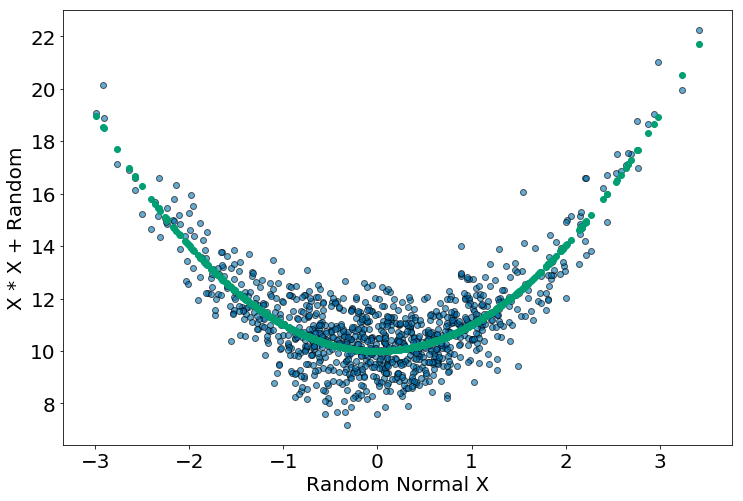

In [27]:
plt.scatter(x, y, edgecolor='k', alpha=0.6)
plt.scatter(x, X @ theta)
plt.xlabel('Random Normal X')
plt.ylabel('X * X + Random')